# GradientBoostingClassifier


## Hyperlinks
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
changesets = pd.read_csv('../data/GradientBoostingClassifier/changesets.csv').dropna()
print(changesets.shape)
changesets.head(2)

(38259, 9)


,ID,user,harmful,create,modify,delete,bbox_area,user_changesets,user_features
0,46139513,hamptonavemapper,False,0.0,2.0,1.0,0.0375,38.0,60434.0
1,46136668,hamptonavemapper,False,102.0,450.0,1.0,0.7897,38.0,60434.0


In [5]:
print('Total problematic: {}'.format(changesets[changesets['harmful'] == True].shape[0]))
print('Total not problematic: {}'.format(changesets[changesets['harmful'] == False].shape[0]))

Total problematic: 4845
Total not problematic: 33414


In [6]:
# Split dataset into random train and test subsets.
from sklearn.cross_validation import train_test_split

X = changesets.drop(['ID', 'user', 'harmful'], axis=1)
# RobustScaler which is suitable for data with outliers.
# X = preprocessing.RobustScaler().fit_transform(X)
X = X.values

y = changesets['harmful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=1)
print(Xtrain.shape, Xtest.shape)

(26781, 6) (11478, 6)


/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# Train a model and get predictions
model = GradientBoostingClassifier()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

In [8]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_model, labels=[True, False], target_names=['problematic', 'not problematic']))

                 precision    recall  f1-score   support

    problematic       0.99      0.64      0.77      1522
not problematic       0.95      1.00      0.97      9956

    avg / total       0.95      0.95      0.95     11478



In [9]:
# Evaluate a score by cross-validation.
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, cv=3)
np.mean(scores)

0.94764630544447048

/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


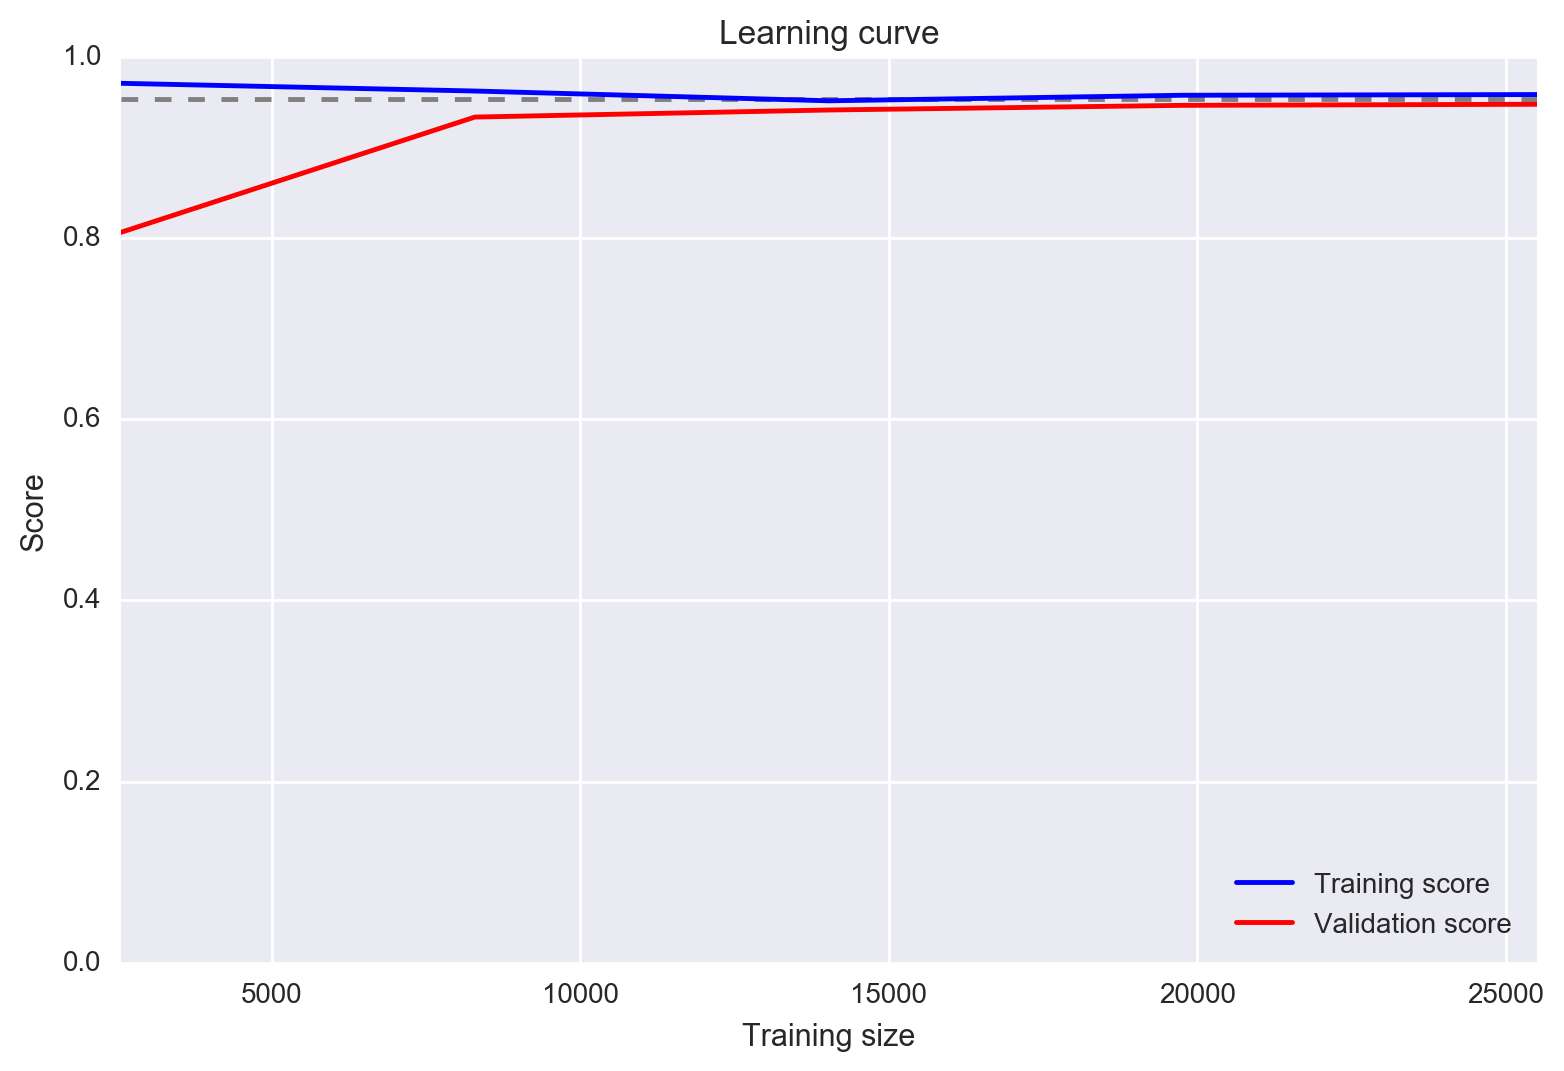

In [10]:
# Learning curve.
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 1)

N, train_lc, val_lc = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 5))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='Training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='Validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('Training size')
ax.set_ylabel('Score')
ax.set_title('Learning curve')
ax.legend(loc='lower right')

plt.tight_layout()

In [11]:
import glob
weekly_dump_directory = '../data/GradientBoostingClassifier/weekly-dump/*.csv'
dump_files = glob.glob(weekly_dump_directory)

In [12]:
print(', '.join(['Date', 'Total changesets', 'Classified problematic', 'Classified not problematic', 'Percentage']))

percentages = []
for dump_file in dump_files:
    changesets_dump = pd.read_csv(dump_file)
    total_changesets = changesets_dump.shape[0]
    
    # Read all columns except the label
    values = changesets_dump.drop(['ID', 'user', 'harmful'], axis=1).dropna().values
    predictions = pd.Series(model.predict(values)).value_counts()
    
    problematic = predictions[True]
    not_problematic = predictions[False]
    percentage = (100.0 * problematic / total_changesets)
    
    percentages.append(percentage)
    print(', '.join([str(item) for item in [dump_file.split('/')[-1].split('.')[0], total_changesets, problematic, not_problematic, round(percentage, 2)]]))
print('Mean: {}%'.format(round(np.mean(percentages), 2)))

Date, Total changesets, Classified problematic, Classified not problematic, Percentage
2017-02-06, 27541, 2, 26037, 0.01
2017-02-07, 31032, 32, 28590, 0.1
2017-02-08, 31302, 13, 26445, 0.04
Mean: 0.05%
